In [1]:
cur_date = "091422"

library(readxl)
library(tidyverse)
library(reshape2)
suppressPackageStartupMessages(library(dendextend))
library(pheatmap)

# reading in files
mediator_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_061722ap.xlsx", sheet = 2))
allostatic_scores_df = data.frame(read_excel("Input/082922_Allostatic_Load_Scores.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
# viewing data
head(mediator_df)
head(allostatic_scores_df)

,Study,Original_Subject_Number,Subject_Number,Group,Subject_ID,Sex,Age,Race,Category,Variable,Value
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,FM2,97,1,CS,CS_1,M,18,B,AL Biomarker,Cortisol,140.304
2,FM2,99,2,CS,CS_2,F,20,W,AL Biomarker,Cortisol,246.542
3,FM2,101,3,CS,CS_3,F,20,W,AL Biomarker,Cortisol,50.878
4,FM2,98,4,CS,CS_4,F,21,W,AL Biomarker,Cortisol,137.387
5,TCORS LAIV,39,5,CS,CS_5,M,21,W,AL Biomarker,Cortisol,116.602
6,FM2,100,6,CS,CS_6,F,22,W,AL Biomarker,Cortisol,54.030


,Group,Covariate,Subject_ID,Allostatic_Load
,<chr>,<chr>,<chr>,<dbl>
1,NS,B,NS_50,3.414885
2,NS,W,NS_41,3.308548
3,NS,W,NS_38,3.164820
4,NS,W,NS_49,2.843204
5,CS,NA,CS_32,2.815147
6,NS,B,NS_62,2.810847


Using hierarchical clustering to create a heatmap to determine how subjects cluster and seeing if those clusters coincide with various covariates including:

    - Allostatic Load (Binary: High vs. Low)
    - Sex
    - Race (Binary: White vs. non-White)
    - Group

In [3]:
# combining into 1 df 
mediator_df = inner_join(mediator_df, allostatic_scores_df %>%
               # removing allostatic scores that were calculated based on stratified covariates
                            filter(Covariate == "NA")) %>%
    filter(Category == "Cytokine") %>%
    # removing covariate and category columns
                            select(-c("Covariate", "Category")) %>%
    # scaling within each subject to standardize
    group_by(Subject_ID) %>%
    mutate(Norm_Value = scale(Value)) %>%
    ungroup() %>%
    # making allostatic load scores binary based on if the allostatic load was < or > 1, making race binary
    mutate(Allostatic_Load_Binary = relevel(factor(ifelse(Allostatic_Load < 1, "Low", "High")), ref = "High"),
          Race_Binary = relevel(factor(ifelse(Race != "W", "NW", Race)), ref = "W"))

# changing the order of the sex and group columns to change the order in the plot legend
mediator_df$Sex = factor(mediator_df$Sex, levels = c("M", "F"))
mediator_df$Group = factor(mediator_df$Group, levels = c("NS", "CS"))

head(mediator_df)

Joining, by = c("Group", "Subject_ID")


Study,Original_Subject_Number,Subject_Number,Group,Subject_ID,Sex,Age,Race,Variable,Value,Allostatic_Load,Norm_Value,Allostatic_Load_Binary,Race_Binary
<chr>,<dbl>,<dbl>,<fct>,<chr>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,"<dbl[,1]>",<fct>,<fct>
FM2,97,1,CS,CS_1,M,18,B,IP10,0.0990,1.054743,-0.3097936,High,NW
FM2,99,2,CS,CS_2,F,20,W,IP10,0.3560,0.830954,-0.3535980,Low,W
FM2,101,3,CS,CS_3,F,20,W,IP10,0.2140,0.521715,-0.3371495,Low,W
FM2,98,4,CS,CS_4,F,21,W,IP10,0.0840,1.867653,-0.3364544,High,W
TCORS LAIV,39,5,CS,CS_5,M,21,W,IP10,123.0310,1.941798,0.1548000,High,W
FM2,100,6,CS,CS_6,F,22,W,IP10,0.1075,0.336339,-0.3365301,Low,W


In [4]:
# determing average cytokine concentrations to order the dataframe for the heat map
avg_cytokine_df = mediator_df %>%
    group_by(Variable) %>%
    # added 1 to each value so I wouldn't have to deal with negatives
    summarize(Avg_Norm_Value = mean(Norm_Value))%>%
    #summarize(Avg_Norm_Value = mean(Value))%>%
    arrange(-Avg_Norm_Value)

head(avg_cytokine_df)

ordered_cytokines = avg_cytokine_df$Variable

Variable,Avg_Norm_Value
<chr>,<dbl>
IP10,1.2603725
IL2,1.1340250
IL13,0.2109725
IL12p70,0.1327670
IL8,-0.1847489
IFNg,-0.3427976


In [5]:
# creating a wider data for plotting that contains subject ids, cytokines, and cytokine concentrations
clustering_df = mediator_df[,c(5,9,12)] %>%
    pivot_wider(names_from = Subject_ID, values_from = Norm_Value) %>%
    column_to_rownames(var = "Variable")

# ordering cytokines for heat map
clustering_df = clustering_df[ordered_cytokines,]

head(clustering_df)

,CS_1,CS_2,CS_3,CS_4,CS_5,CS_6,CS_7,CS_8,CS_9,CS_10,⋯,NS_54,NS_55,NS_56,NS_57,NS_58,NS_59,NS_60,NS_61,NS_62,NS_63
,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
IP10,-0.3097936,-0.3535980,-0.3371495,-0.3364544,0.1548000,-0.3365301,2.3073232,2.4391589,-0.381926391,2.65753486,⋯,2.0753395,-0.3236678,3.0140934,0.00549844,1.43637598,2.80337589,2.998152529,-0.3014920,3.0149070,3.00393370
IL2,3.0148892,3.0065796,3.0105207,3.0104167,2.9735687,3.0107197,1.6874941,1.5068728,2.986848027,0.12997016,⋯,-0.3404068,3.0125357,-0.2556577,0.78254920,1.67385210,-0.04242550,0.005292422,3.0151134,-0.2689759,-0.04830226
IL13,-0.2803758,-0.1434741,-0.2086436,-0.1526827,-0.2652335,-0.2018996,-0.3250540,-0.2481815,-0.054493089,0.44726373,⋯,1.9374093,-0.3193255,-0.2806684,1.27054702,1.39232508,0.39515999,-0.274510893,-0.3015131,-0.2987132,-0.28492109
IL12p70,-0.2779663,-0.1760377,-0.1842951,-0.2543752,-0.1769350,-0.1912506,-0.2783291,-0.4294905,-0.007113604,0.52850926,⋯,-0.3047186,-0.1876522,-0.3150344,0.50607824,-0.06036361,-0.07739296,-0.280352483,-0.3015126,-0.3045902,-0.30503799
IL8,-0.2929249,-0.2845050,-0.2791911,-0.2941340,-0.3489452,-0.2960123,-0.4497645,-0.3865879,-0.297039649,0.05289088,⋯,-0.2237869,-0.2660784,-0.2605298,2.00484508,-0.07417636,0.07053032,-0.329552734,-0.3015135,-0.2978912,-0.32232845
IFNg,-0.3061311,-0.2898131,-0.3227203,-0.2998984,-0.3838176,-0.3081068,-0.4620076,-0.4674050,-0.351786221,-0.55269825,⋯,-0.3616830,-0.3087413,-0.2900001,-0.65841367,-0.66200539,-0.01448162,-0.343668666,-0.3015136,-0.3000151,-0.33472577


# Hierarchical Clustering Heat Map

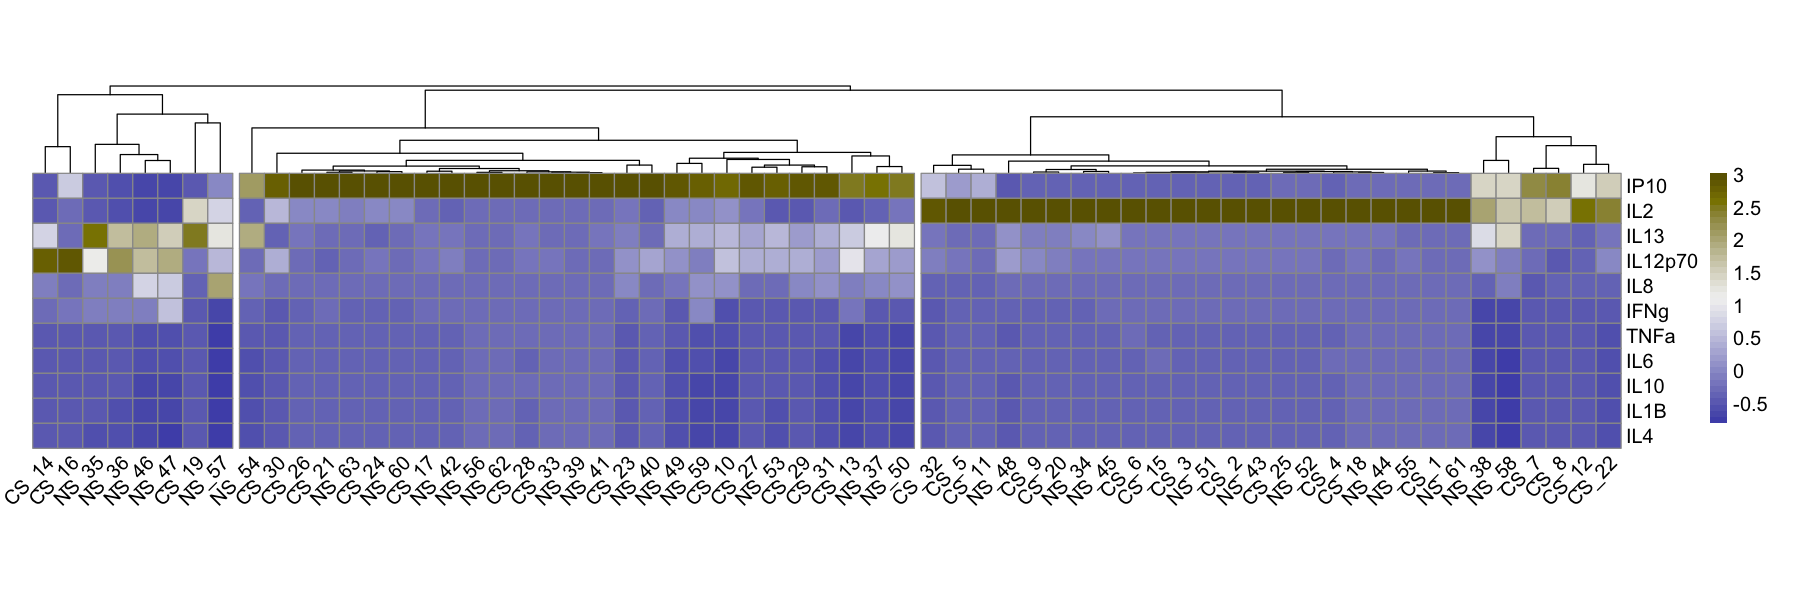

In [6]:
options(repr.plot.width=15, repr.plot.height=5) #changing size
pheatmap(clustering_df, cluster_rows = FALSE, cluster_cols = TRUE, legend = TRUE,
         angle_col = 45, fontsize = 12,  
         cellheight = 15, cellwidth = 15,
         color = hcl.colors(40, "Blue-Yellow 2"),
         cutree_col = 3) # adds a break bewtween the largest clusters

# Heat Map w/ Covariates

In [7]:
# creating a covariates df for the annotation column
covariates_df = mediator_df %>%
    select(c("Subject_ID", "Group", "Sex", "Race_Binary", "Allostatic_Load_Binary")) %>%
    unique() %>%
    column_to_rownames(var = "Subject_ID")

# changing colnames so it looks better in the figure
colnames(covariates_df) = c("Group", "Sex", "Race", "Allostatic Load")

head(covariates_df)

,Group,Sex,Race,Allostatic Load
,<fct>,<fct>,<fct>,<fct>
CS_1,CS,M,NW,High
CS_2,CS,F,W,Low
CS_3,CS,F,W,Low
CS_4,CS,F,W,High
CS_5,CS,M,W,High
CS_6,CS,F,W,Low


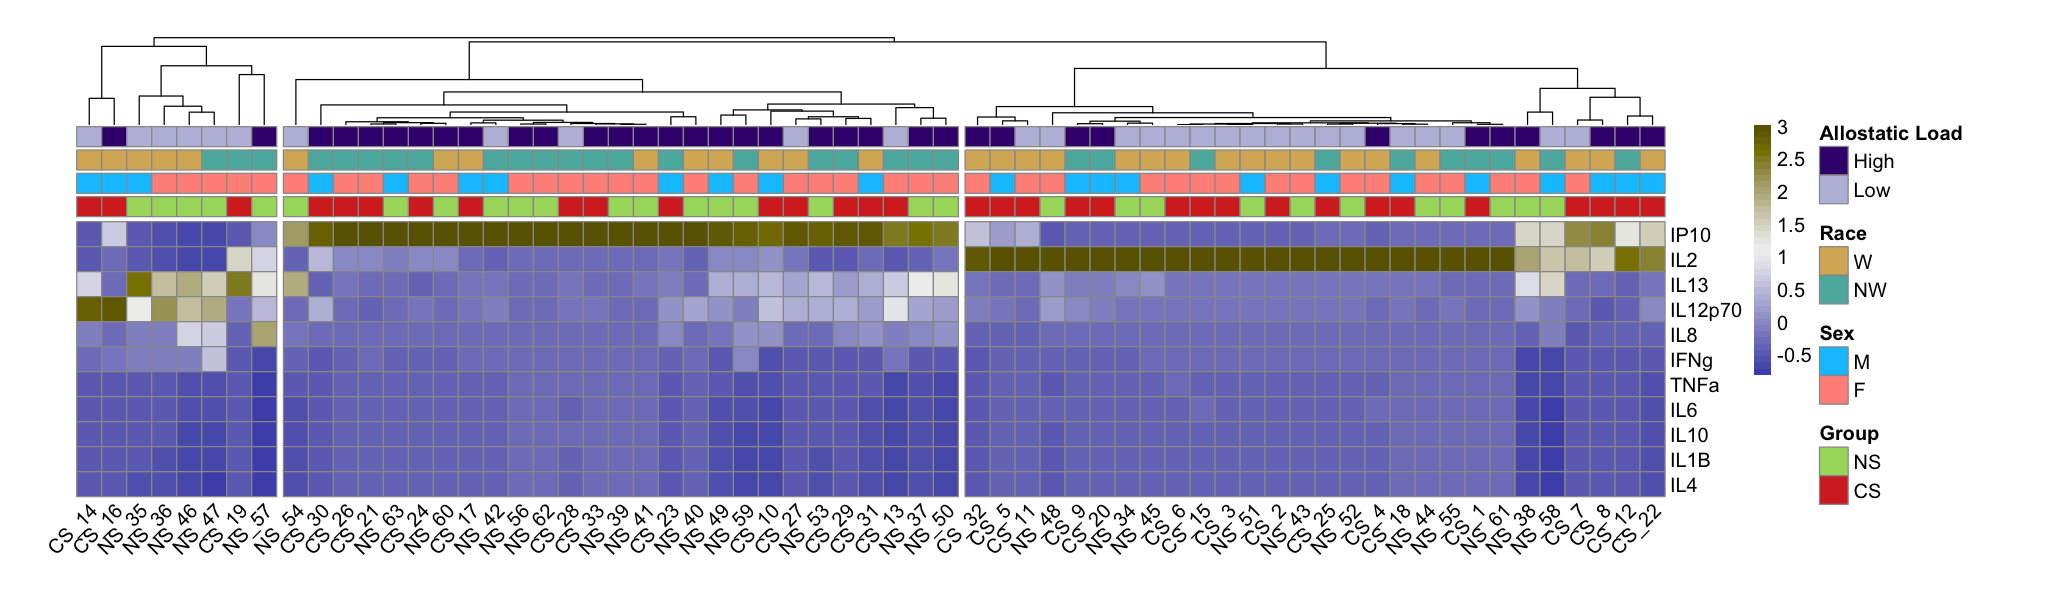

In [8]:
options(repr.plot.width=17.2, repr.plot.height=5) #changing size
pheatmap(clustering_df, cluster_rows = FALSE, cluster_cols = TRUE, legend = TRUE,
         angle_col = 45, fontsize = 12,  
         cellheight = 15, cellwidth = 15,
         color = hcl.colors(40, "Blue-Yellow 2"),
         cutree_col = 3, # adds a break bewtween the largest clusters
         annotation_col = covariates_df, annotation_names_col = FALSE, # adding in covariates
         annotation_colors = list(`Allostatic Load` = c(High = "#3f007d", Low = "#bcbddc"),
                                 Race = c(W = "#d8b365", NW = "#5ab4ac"),
                                 Group = c(NS = "#a6d96a", CS = "#d73027")))

In [ ]:
# axes labels?